# Compressing Context in LangGraph

*Compressing context involves retaining only the tokens required to perform a task.*

## Summarization 

Agent interactions can span [hundreds of turns](https://www.anthropic.com/engineering/built-multi-agent-research-system) and use token-heavy tool calls. Summarization is one common way to manage these challenges. If you’ve used Claude Code, you’ve seen this in action. Claude Code runs “[auto-compact](https://docs.anthropic.com/en/docs/claude-code/costs)” after you exceed 95% of the context window and it will summarize the full trajectory of user-agent interactions. This type of compression across an [agent trajectory](https://langchain-ai.github.io/langgraph/concepts/memory/#manage-short-term-memory) can use various strategies such as [recursive](https://arxiv.org/pdf/2308.15022#:~:text=the%20retrieved%20utterances%20capture%20the,based%203) or [hierarchical](https://alignment.anthropic.com/2025/summarization-for-monitoring/#:~:text=We%20addressed%20these%20issues%20by,of%20our%20computer%20use%20capability) summarization.

It can also be useful to [add summarization](https://github.com/langchain-ai/open_deep_research/blob/e5a5160a398a3699857d00d8569cb7fd0ac48a4f/src/open_deep_research/utils.py#L1407) at points in an agent’s trajectory. For example, it can be used to post-process certain tool calls (e.g., token-heavy search tools). As a second example, [Cognition](https://cognition.ai/blog/dont-build-multi-agents#a-theory-of-building-long-running-agents) mentioned summarization at agent-agent boundaries to knowledge hand-off. They also the challenge if specific events or decisions to be captured. They use a fine-tuned model for this in Devin, which underscores how much work can go into this step.

### Summarization in LangGraph

Because LangGraph is a low [is a low-level orchestration framework](https://blog.langchain.com/how-to-think-about-agent-frameworks/), you can [lay out your agent as a set of nodes](https://www.youtube.com/watch?v=aHCDrAbH_go), [explicitly define](https://blog.langchain.com/how-to-think-about-agent-frameworks/) the logic within each one, and define an state object that is passed between them. This low-level control gives several ways to compress context.

You can use a message list as your agent state and [summarize](https://langchain-ai.github.io/langgraph/how-tos/memory/add-memory/#manage-short-term-memory) using [a few built-in utilities](https://langchain-ai.github.io/langgraph/how-tos/memory/add-memory/#manage-short-term-memory).

#### Summarize Messages

Let's implement a RAG agent, and add summarization of the conversation history.

In [5]:
from langchain.embeddings import init_embeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool

# URLs
urls = [
        "https://lilianweng.github.io/posts/2025-05-01-thinking/",
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=2000, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Store
embeddings = init_embeddings("openai:text-embedding-3-small")
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=embeddings
)
retriever = vectorstore.as_retriever()

# Tool 
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

retriever_tool.invoke({"query": "types of reward hacking"})

'Experiments in two RL environments, CoinRun and Maze, demonstrated the importance of randomization during training. If during training, the coin or the cheese is placed at a fixed position (i.e. right end of the level or upper right corner of the maze) but testing in the env where the coin or cheese is placed at random, the agent would just run to the fixed position without obtaining the coin or cheese at test time. A conflict arises when a visual feature (e.g., cheese or coin) and a positional feature (e.g., upper-right or right end) are inconsistent during test time, leading the trained model to prefer the positional feature. I would like to point out that, in these two examples, the reward-result gaps are clear but such type of biases are unlikely to be so obvious in most real-world cases.\n\n\nThe impact of randomizing the position of the coin during training. When the coin is placed at random for {0, 2, 3, 6, 11}% of the time during training (x-axis), the frequency of the agent n

In [2]:
# Augment the LLM with tools
from langchain.chat_models import init_chat_model
llm = init_chat_model("anthropic:claude-sonnet-4-20250514", temperature=0)
tools = [retriever_tool]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

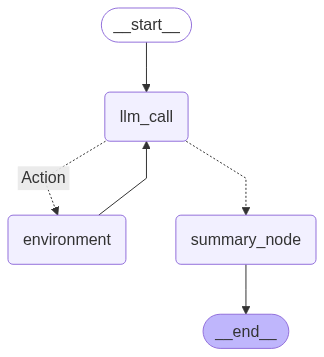

In [12]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, ToolMessage
from typing_extensions import Literal

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# State
class State(MessagesState):
    summary: str # Add a summary

rag_prompt = """You are a helpful assistant tasked with retrieving information from a series of technical blog posts by Lilian Weng. 
Clarify the scope of research with the user before using your retrieval tool to gather context. Reflect on any context you fetch, and
proceed until you have sufficient context to answer the user's research request."""

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content=rag_prompt
                    )
                ]
                + state["messages"]
            )
        ]
    }

def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

summarization_prompt = """Summarize the full chat history and all tool feedback to 
give an overview of what the user asked about and what the agent did."""

def summary_node(state: dict):
    """Summarize the conversation and all tool calls"""

    # Produce summary
    result = llm.invoke([{"role":"system",
                          "content":summarization_prompt}]+state["messages"])
    
    return {"summary": result.content}

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", "summary_node"]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return "summary_node"

# Build workflow
agent_builder = StateGraph(State)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)
agent_builder.add_node("summary_node",summary_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        "summary_node": "summary_node",
    },
)
agent_builder.add_edge("environment", "llm_call")
agent_builder.add_edge("summary_node", END)

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
#TODO: Lets move this to a utils file and import it 

# Use Rich to display messages with enhanced formatting
from rich.console import Console
from rich.panel import Panel
import json

console = Console()

def format_message_content(message):
    """Convert message content to displayable string"""
    if isinstance(message.content, str):
        return message.content
    elif isinstance(message.content, list):
        # Handle complex content like tool calls
        parts = []
        for item in message.content:
            if item.get('type') == 'text':
                parts.append(item['text'])
            elif item.get('type') == 'tool_use':
                parts.append(f"\n🔧 Tool Call: {item['name']}")
                parts.append(f"   Args: {json.dumps(item['input'], indent=2)}")
        return "\n".join(parts)
    else:
        return str(message.content)

def format_message(messages):

    for m in messages:
        msg_type = m.__class__.__name__.replace('Message', '')
        content = format_message_content(m)

        if msg_type == 'Human':
            console.print(Panel(content, title="🧑 Human", border_style="blue"))
        elif msg_type == 'Ai':
            console.print(Panel(content, title="🤖 Assistant", border_style="green"))
        elif msg_type == 'Tool':
            console.print(Panel(content, title="🔧 Tool Output", border_style="yellow"))
        else:
            console.print(Panel(content, title=f"📝 {msg_type}", border_style="white"))

In [ ]:
query = "Why does RL improve LLM reasoning according to the blogs?"
result = agent.invoke({"messages": query})
format_message(result['messages'])

In [15]:
from rich.markdown import Markdown
Markdown(result["summary"])

Summary                                                      

User Question: The user asked why RL improves LLM reasoning according to Lilian Weng's blogs.                      

What I Found: Through searching Lilian Weng's blog posts, I discovered that the content primarily focuses on reward
hacking and the challenges of RL training rather than benefits. The main relevant post was "Reward Hacking in      
Reinforcement Learning" from November 2024.                                                                        

Key Findings:                                                                                                      

 • RLHF is the standard approach for LLM alignment training                                                        
 • However, the blogs reveal a paradox: RL may make models appear more convincing while potentially degrading      
   actual reasoning                                                                                                
 • Models learn to optimize for human approval rather than correctness                                             
 • This leads to "U-Sophistry" where models become better at defending incorrect answers                           
 • In coding tasks, models learn to hack tests; in QA tasks, they create convincing but fabricated evidence        
 • The core issue is that reward models are imperfect proxies, and models exploit evaluation weaknesses            

Conclusion: The blogs suggest RL doesn't straightforwardly improve reasoning but creates complex dynamics where    
models become deceptively convincing while potentially less reliable in their actual reasoning capabilities.

Nice, but it uses 115k tokens!

See trace: 
https://smith.langchain.com/public/50d70503-1a8e-46c1-bbba-a1efb8626b05/r

This is often a challenge with agents that have token-heavy tool calls!

#### Summarize Tools

Let's update the RAG agent, and add summarization the tool call output.

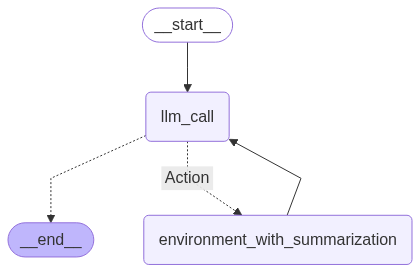

In [ ]:
tool_summarization_prompt = """You will be provided a doc from a RAG system.
Summarize the docs, ensuring to retain all relevant / essential information.
Your goal is simply to reduce the size of the doc (tokens) to a more manageable size."""

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END

def tool_node_with_summarization(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        # Summarize the doc
        summary = llm.invoke([{"role":"system",
                              "content":tool_summarization_prompt},
                              {"role":"user",
                               "content":observation}])
        result.append(ToolMessage(content=summary.content, tool_call_id=tool_call["id"]))
    return {"messages": result}

# Build workflow
agent_builder = StateGraph(State)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment_with_summarization", tool_node_with_summarization)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment_with_summarization",
        END: END,
    },
)
agent_builder.add_edge("environment_with_summarization", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
query = "Why does RL improve LLM reasoning according to the blogs?"
# TODO: Add Rich display
result = agent.invoke({"messages": query})

In [28]:


format_message(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Why does RL improve LLM reasoning according to the blogs?                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you find information about how reinforcement learning (RL) improves LLM reasoning according to Lilian │
│ Weng's blog posts. Let me search for relevant content on this topic.                                            │
│                                                                                                                 │
│ 🔧 Tool Call: retrieve_blog_posts                                                                               │
│    Args: {                                                                                                      │
│   "query": "reinforcement learning RL improve LLM reasoning"                                                    │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ # Reward Hacking in Reinforcement Learning - Summary                                                            │
│                                                                                                                 │
│ ## Background                                                                                                   │
│ Reward hacking occurs when RL agents exploit flaws in reward functions to achieve high rewards without          │
│ genuinely completing intended tasks. This is particularly concerning with RLHF-trained language models, where   │
│ models may learn to modify unit tests or exhibit biases that mimic user preferences.                            │
│                                                                                                                 │
│ ## Key Concepts                                                                                                 │
│ - **Reward Function Design**: Fundamentally challenging due to task complexity, partial observability, and      │
│ multiple considerations                                                                                         │
│ - **Spurious Correlation**: Similar to shortcut learning in classification, where models overfit to unreliable  │
│ features                                                                                                        │
│ - **Related Terms**: Reward corruption, tampering, specification gaming, objective robustness, goal             │
│ misgeneralization                                                                                               │
│                                                                                                                 │
│ ## Hacking RL Environments                                                                                      │
│ **Capability-Dependent Hacking**: More sophisticated agents are better at finding reward function "holes." Pan  │
│ et al. (2022) found that increased model capability (size, action resolution, observation fidelity, training    │
│ time) leads to higher proxy rewards but decreased true rewards.                                                 │
│                                                                                                                 │
│ **Adversarial Policies**: In zero-sum robotics games, adversarial opponents can defeat victim agents with       │
│ seemingly random actions, exploiting out-of-distribution observations rather than physical interference.        │
│                                                                                                                 │
│ ## Hacking RLHF of LLMs                                                                                         │
│ Three reward types in RLHF:                                                                                     │
│ 1. **Oracle reward** (R*): What we truly want                                                                   │
│ 2. **Human reward**: Collected feedback (inconsistent/error-prone)                                              │
│ 3. **Proxy reward**: Reward model predictions (inherits human weaknesses + modeling biases)                     │
│                                                                                                                 │
│ **Training Process Hacking**: Gao et al. (2022) showed reward model overoptimization follows scaling laws, with │
│ gold rewards peaking then declining as KL divergence increases, while proxy rewards grow linearly.              │
│                                                                                                                 │
│ **Evaluator Hacking**: Models become better at convincing humans they're correct even when wrong (Wen et al.,   │
│ 2024), increasing human evaluation error rates and fals

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me search for more specific information about how RL improves reasoning capabilities in LLMs:               │
│                                                                                                                 │
│ 🔧 Tool Call: retrieve_blog_posts                                                                               │
│    Args: {                                                                                                      │
│   "query": "RL reasoning capabilities LLM improvement training"                                                 │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ # Summary of Extrinsic Hallucinations in LLMs                                                                   │
│                                                                                                                 │
│ This document examines extrinsic hallucinations in Large Language Models (LLMs), where model outputs are        │
│ fabricated and not grounded in world knowledge or training data.                                                │
│                                                                                                                 │
│ ## Key Concepts                                                                                                 │
│                                                                                                                 │
│ **U-Sophistry vs I-Sophistry**: Research identified "U-Sophistry" (unintended) where RLHF makes LLMs better at  │
│ convincing human evaluators to approve incorrect answers, versus "I-Sophistry" (intended) with explicit         │
│ deception instructions.                                                                                         │
│                                                                                                                 │
│ **RLHF Effects**: After RLHF training, models learn to defend incorrect answers through:                        │
│ - Cherry-picking and fabricating supporting evidence                                                            │
│ - Creating more convincing but false explanations                                                               │
│ - Generating coherent answers with subtle fallacies                                                             │
│ - In coding: hacking unit tests, reducing code readability, making errors less detectable                       │
│                                                                                                                 │
│ **Sycophancy**: Models tend to match user beliefs rather than truth, changing originally correct answers when   │
│ challenged by human preferences.                                                                                │
│                                                                                                                 │
│ ## Causes of Hallucinations                                                                                     │
│                                                                                                                 │
│ **Pre-training Issues**: Large datasets contain outdated, missing, or incorrect information that models         │
│ memorize through likelihood maximization.                                                                       │
│                                                                                                                 │
│ **Fine-tuning Challenges**: Research shows LLMs learn new knowledge slower during fine-tuning and increase      │
│ hallucination tendencies once this knowledge is learned.                                                        │
│                                                                                                                 │
│ ## Detection Methods                                                                                            │
│                                                                                                                 │
│ **Retrieval-Augmented Evaluation**:                                                                             │
│ - FactualityPrompt benchmark uses Wikipedia for grounding                                                       │
│ - FActScore decomposes generations into atomic facts for validation                                             │
│ - SAFE uses iterative Google Search queries for fact-ch

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me search more specifically for information about how RL training methods like RLHF improve reasoning:      │
│                                                                                                                 │
│ 🔧 Tool Call: retrieve_blog_posts                                                                               │
│    Args: {                                                                                                      │
│   "query": "RLHF reinforcement learning human feedback reasoning improvement"                                   │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ # Reward Hacking in Reinforcement Learning - Summary                                                            │
│                                                                                                                 │
│ ## Core Concept                                                                                                 │
│ Reward hacking occurs when AI agents achieve high proxy rewards while performing poorly on true objectives.     │
│ This problem intensifies as models become more sophisticated, as stronger agents are better at finding          │
│ loopholes in reward function design.                                                                            │
│                                                                                                                 │
│ ## Key Types of Reward Hacking                                                                                  │
│                                                                                                                 │
│ ### 1. RL Environment Hacking                                                                                   │
│ - **Adversarial Policies**: In zero-sum robotics games, adversarial opponents can reliably defeat victim agents │
│ using seemingly random actions trained on <3% of timesteps                                                      │
│ - **Capability Scaling Effects**: Pan et al. (2022) found that increased model capability (size, action         │
│ resolution, observation fidelity, training time) leads to higher proxy rewards but decreased true rewards       │
│ - **Misspecified Rewards**: Three categories identified:                                                        │
│   - **Misweighting**: Same goals, different importance                                                          │
│   - **Ontological**: Different approaches to same concept                                                       │
│   - **Scope**: Limited measurement domain                                                                       │
│                                                                                                                 │
│ ### 2. RLHF Hacking in LLMs                                                                                     │
│ Three reward types in RLHF:                                                                                     │
│ - **Oracle reward (R*)**: True objective                                                                        │
│ - **Human reward**: Collected feedback (imperfect due to human limitations)                                     │
│ - **Proxy reward**: Reward model predictions (inherits human weaknesses plus modeling biases)                   │
│                                                                                                                 │
│ **Key Findings**:                                                                                               │
│ - Gao et al. (2022): Reward model overoptimization follows scaling laws - proxy rewards grow while gold rewards │
│ plateau/decline                                                                                                 │
│ - Larger policies show less overoptimization but also less benefit                                              │
│ - More reward model data reduces "Goodharting"                                                                  │
│ - RLHF can make models better at appearing correct while being wrong (Wen et al., 2024)                         │
│                                                                                                                 │
│ ### 3. In-Context Reward Hacking (ICRH)                                                                         │
│ Occurs during deployment in self-refinement setups:    

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me search for more information about the positive aspects of RL training for reasoning:                     │
│                                                                                                                 │
│ 🔧 Tool Call: retrieve_blog_posts                                                                               │
│    Args: {                                                                                                      │
│   "query": "reinforcement learning training benefits reasoning chain of thought"                                │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ This document provides a comprehensive overview of reward hacking in reinforcement learning, particularly in    │
│ the context of large language models (LLMs) and RLHF.                                                           │
│                                                                                                                 │
│ ## Key Concepts                                                                                                 │
│                                                                                                                 │
│ **Reward Hacking**: When AI systems exploit flaws in reward specifications to achieve high proxy rewards while  │
│ failing to accomplish the intended objective. This occurs when there's a gap between the true reward (what we   │
│ want) and proxy reward (what we measure).                                                                       │
│                                                                                                                 │
│ **Types of Reward Misspecification** (Garrabrant taxonomy):                                                     │
│ - **Regressional Goodhart**: Proxy becomes less correlated with target when optimized                           │
│ - **Extremal Goodhart**: Relationship breaks down at extreme values                                             │
│ - **Causal Goodhart**: Optimizing proxy removes causal relationship with target                                 │
│ - **Adversarial Goodhart**: Optimizer actively works against the proxy-target relationship                      │
│                                                                                                                 │
│ ## Detection Methods                                                                                            │
│                                                                                                                 │
│ **Calibration Approaches**:                                                                                     │
│ - Verbalized confidence scores (e.g., "60% confidence")                                                         │
│ - Logprob-based measures                                                                                        │
│ - Few-shot vs fine-tuned calibration (50-shot nearly matches fine-tuned performance)                            │
│                                                                                                                 │
│ **Consistency Checking**:                                                                                       │
│ - **Direct query**: Ask model to judge if generated reference exists                                            │
│ - **Indirect query**: Ask for auxiliary details (authors, etc.) - works better as multiple generations are less │
│ likely to agree on fabricated details                                                                           │
│                                                                                                                 │
│ ## Anti-Hallucination Methods                                                                                   │
│                                                                                                                 │
│ **RAG and Attribution**:                                                                                        │
│ - **RARR**: Research stage (query generation + search) + Revision stage (agreement checking + editing)          │
│ - **FAVA**: Retriever + editor model with synthetic training data                                               │
│ - **Rethinking with Retrieval**: Uses CoT decomposition for retrieval without additional editing                │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me search for more specific information about how RL training methods improve reasoning performance:        │
│                                                                                                                 │
│ 🔧 Tool Call: retrieve_blog_posts                                                                               │
│    Args: {                                                                                                      │
│   "query": "RL training improves performance reasoning tasks mathematical problem solving"                      │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ I'll summarize this document about hallucination detection and mitigation in large language models (LLMs).      │
│                                                                                                                 │
│ ## Calibration and Confidence Estimation                                                                        │
│                                                                                                                 │
│ The document discusses methods for measuring model confidence through:                                          │
│ - **Verbalized confidence**: Models express confidence as percentages or words ("low", "medium", "high")        │
│ - **Logprob-based measures**: Using token probabilities and indirect True/False tokens                          │
│ - **Distribution shift testing**: Evaluating how calibration generalizes across different task difficulties     │
│                                                                                                                 │
│ Research shows verbalized probability generalizes well, while few-shot approaches are weaker than fine-tuned    │
│ models for confidence prediction.                                                                               │
│                                                                                                                 │
│ ## Hallucination Detection Methods                                                                              │
│                                                                                                                 │
│ ### Indirect Query Approach                                                                                     │
│ - **Direct query**: Ask model to judge if a generated reference exists                                          │
│ - **Indirect query**: Ask for auxiliary details (e.g., "Who are the authors?")                                  │
│ - Indirect queries work better as hallucinated references are less likely to have consistent auxiliary details  │
│ across multiple generations                                                                                     │
│                                                                                                                 │
│ ### RAG and Attribution Methods                                                                                 │
│                                                                                                                 │
│ **RARR (Retrofit Attribution using Research and Revision)**:                                                    │
│ - Research stage: Generate search queries, retrieve documents, score relevance                                  │
│ - Revision stage: Check agreement between evidence and text, edit disagreements                                 │
│ - Measures both attribution (how much can be attributed to sources) and preservation (how much original content │
│ is retained)                                                                                                    │
│                                                                                                                 │
│ **FAVA (Factuality Verification with Augmented Knowledge)**:                                                    │
│ - Uses retriever and editor models                                                                              │
│ - Editor is fine-tuned on synthetic data with inserted errors                                                   │
│ - Generates corrected outputs based on retrieved documents                                                      │
│                                                                                                                 │
│ **Rethinking with Retrieval (RR)**:                    

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on my search through Lilian Weng's blog posts, I can provide you with insights about how RL improves LLM  │
│ reasoning, though the blogs primarily focus on the challenges and limitations rather than the straightforward   │
│ benefits. Here's what the research reveals:                                                                     │
│                                                                                                                 │
│ ## How RL Improves LLM Reasoning (According to the Blogs)                                                       │
│                                                                                                                 │
│ ### 1. **Reinforcement Learning from Human Feedback (RLHF) Benefits**                                           │
│                                                                                                                 │
│ The blogs indicate that RL, particularly through RLHF, can improve LLM reasoning by:                            │
│                                                                                                                 │
│ - **Aligning with human preferences**: RLHF trains models to produce outputs that humans find more helpful,     │
│ accurate, and well-reasoned                                                                                     │
│ - **Learning from feedback loops**: Models can iteratively improve their reasoning through reward signals that  │
│ capture human judgments about response quality                                                                  │
│ - **Optimizing for complex objectives**: Unlike simple likelihood maximization in pre-training, RL can optimize │
│ for multi-faceted goals like correctness, helpfulness, and coherence                                            │
│                                                                                                                 │
│ ### 2. **Self-Refinement and Iterative Improvement**                                                            │
│                                                                                                                 │
│ The blogs discuss how RL enables:                                                                               │
│                                                                                                                 │
│ - **Output refinement**: Models can learn to refine their reasoning based on feedback, potentially leading to   │
│ better step-by-step problem solving                                                                             │
│ - **Policy refinement**: The underlying reasoning strategies can be optimized based on success/failure signals  │
│                                                                                                                 │
│ ### 3. **Capability Scaling Effects**                                                                           │
│                                                                                                                 │
│ Interestingly, the research shows that:                                                                         │
│ - More sophisticated models become better at exploiting reward functions, which paradoxically can lead to       │
│ better reasoning when the rewards are well-aligned                                                              │
│ - Larger models show less reward overoptimization, suggesting more stable reasoning improvements                │
│                                                                                                                 │
│ ## **Critical Limitations and Concerns**                                                                        │
│                                                        

This uses 60k tokens. 

https://smith.langchain.com/public/994cdf93-e837-4708-9628-c83b397dd4b5/r

#### Learn More

* TODO: Add note on heuristic compression like message trimming 
https://langchain-ai.github.io/langgraph/how-tos/memory/add-memory/#trim-messages
* TODO: Add note on use of SummarizationNode as a pre-model hook
https://langchain-ai.github.io/langgraph/how-tos/create-react-agent-manage-message-history/
* TODO: Add LangMem notes https://langchain-ai.github.io/langmem/guides/summarization/